## Bias Detection in the Judicial System
In this notebook, we analyze the (simulated) data set of crime elements for the crime type **"Burglary"**. The data set consists of the following variables:
* **Crime Elements** - an element of a crime is one of a set of facts that must all be proven to convict a defendant of a crime. For the Burglary data set we have the following possible crime elements:
    * Breaking&Entering
    * Stated intent with partner	
    * Happened at night
    * Elements of assault identified
    * Elements of theft identified
    The values of these variables are boolean i.e. True or False
* **Race** - Demographic information of the defendant. We have included the following:
    * White
    * Black
    * Hispanic
    * Other
* **Sentencing** - The length of sentencing charged for the defendant
* **Stage of Legal Procedure** - This variable corresponds to our "bias output" detection i.e. it is used to indicate in which stage of the legal process is the bias detected to be the highest among various ethnic groups. The stages of legal process we considered are:
    * Investigation
    * Initial Hearing/Arraignment
    * Plea Bargaining
    * Pre-Motion Trials

In [1]:
!pip3 install aif360
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pandas
!pip3 install seaborn
!pip3 install catscatter

  Could not find a version that satisfies the requirement catscatter (from versions: )
No matching distribution found for catscatter


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# sns.set_style('white')

from aif360.sklearn.metrics import *

In [5]:
df = pd.read_csv("data/weighted_crime_elements_data_for_burglary.csv", usecols=[1,2,3,4,5,6,7,8])
df.head()

,Breaking&Entering,Stated intent with partner,Happened at night,Elements of assault identified,Elements of theft identified,Race,Stage of Legal Procedure,Sentencing
0,True,True,True,False,True,Black,Investigation,0
1,True,True,False,False,True,Black,Plea Bargaining,1
2,False,True,True,False,True,Other,Plea Bargaining,4
3,False,True,False,True,True,White,Investigation,1
4,True,False,True,True,True,Other,Investigation,2


In [6]:
print("Number of rows:",len(df))

Number of rows: 5000


In [ ]:
#df1 = pd.get_dummies(df, columns=['Stage of Legal Procedure']).head()
#df1['Stage of Legal Procedure_Initial Hearing/Arraignment'] = df1['Stage of Legal Procedure_Initial Hearing/Arraignment'].astype('bool')
#df1['Stage of Legal Procedure_Investigation'] = df1['Stage of Legal Procedure_Investigation'].astype('bool')
#df1['Stage of Legal Procedure_Plea Bargaining'] = df1['Stage of Legal Procedure_Plea Bargaining'].astype('bool')
#df1['Stage of Legal Procedure_Pre-Trial Motions'] = df1['Stage of Legal Procedure_Pre-Trial Motions'].astype('bool')

In [ ]:
#df1.head()

## Understanding the Distribution among Race vs Crime Charges/Fact Patterns

In [7]:
def DI_table(prot_attr=None):
    with np.errstate(divide='ignore'):
        pct = [Y.xs(g, level=prot_attr).shape[0]/Y.shape[0] for g in Y.index.unique(prot_attr)]
        data = [[np.divide(1, disparate_impact_ratio(Y[Y[prev]][stage], prot_attr=prot_attr, priv_group=g))
                 for stage, prev in zip(Y.columns[1:], Y.columns)]
                for g in Y.index.unique(prot_attr)]
        table = pd.DataFrame(np.c_[pct, data],
                columns=['proportion of defendants'] + Y.columns[1:].tolist(),
                index=Y.index.unique(prot_attr)).sort_index()
    def colorize(di):
        # lambda x: 'color: red' if x < 0.8 or x > 1.25 else ''
        if di < 0.8:
            return 'color: red'
        elif di > 1.25:
            return 'color: blue'
        return ''
    return table.style.format('{:.3f}').format({'proportion of defendants': '{:.1%}'}
            ).bar(subset='proportion of defendants', align='zero', color='#5fba7d'
            ).applymap(colorize, subset=Y.columns[1:])

In [ ]:
#Y = df1.set_index(['Race','Sentencing'])
#Y = Y.drop(columns=['Stage of Legal Procedure_Initial Hearing/Arraignment', 'Stage of Legal Procedure_Investigation','Stage of Legal Procedure_Plea Bargaining','Stage of Legal Procedure_Pre-Trial Motions'])

In [8]:
Y = df
Y = Y.set_index(['Race','Sentencing','Stage of Legal Procedure'])
Y.head()

Breaking&Entering  \
Race  Sentencing Stage of Legal Procedure                      
Black 0          Investigation                          True   
      1          Plea Bargaining                        True   
Other 4          Plea Bargaining                       False   
White 1          Investigation                         False   
Other 2          Investigation                          True   

                                           Stated intent with partner  \
Race  Sentencing Stage of Legal Procedure                               
Black 0          Investigation                                   True   
      1          Plea Bargaining                                 True   
Other 4          Plea Bargaining                                 True   
White 1          Investigation                                   True   
Other 2          Investigation                                  False   

                                           Happened at night  \
Race  Sentencing Stage of Legal Procedure                      
Black 0          Investigation                          True   
      1          Plea Bargaining                       False   
Other 4          Plea Bargaining                        True   
White 1          Investigation                         False   
Other 2          Investigation                          True   

                                           Elements of assault identified  \
Race  Sentencing Stage of Legal Procedure                                   
Black 0          Investigation                                      False   
      1          Plea Bargaining                                    False   
Other 4          Plea Bargaining                                    False   
White 1          Investigation                                       True   
Other 2          Investigation                                       True   

                                           Elements of theft identified  
Race  Sentencing Stage of Legal Procedure                                
Black 0          Investigation                                     True  
      1          Plea Bargaining                                   True  
Other 4          Plea Bargaining                                   True  
White 1          Investigation                                     True  
Other 2          Investigation                                     True

In [9]:
DI_table()

/home/hemaveeradhi/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
DI_table('Race')

,proportion of defendants,Stated intent with partner,Happened at night,Elements of assault identified,Elements of theft identified
Race,,,,,
Black,25.0%,0.977,0.961,1.045,0.976
Hispanic,25.4%,0.970,1.043,1.093,1.055
Other,24.7%,1.051,0.990,0.922,0.935
White,24.8%,1.003,1.008,0.948,1.036


In [11]:
DI_table('Sentencing')

,proportion of defendants,Stated intent with partner,Happened at night,Elements of assault identified,Elements of theft identified
Sentencing,,,,,
0,12.6%,0.987,1.031,0.913,1.060
1,18.0%,1.063,1.003,0.986,1.038
2,18.9%,1.010,1.019,1.059,0.959
3,21.2%,1.040,1.011,1.043,1.003
4,16.9%,0.986,0.907,0.968,1.058
5,12.5%,0.876,1.047,1.003,0.878


In [ ]:
#Y = df1
#Y = Y.drop(columns=['Breaking&Entering','Stated intent with partner','Happened at night','Elements of assault identified','Elements of theft identified'])
#Y = Y.set_index(['Race','Sentencing'])
#Y.head()

In [12]:
def DI_grid():
    num_stages = Y.columns.size - 1
    f, axes = plt.subplots(1, num_stages, figsize=(2+4*num_stages, 12), squeeze=True, sharey=True)
    for ax, stage, cond in zip(axes, Y.columns[1:], Y.columns):
        rates = Y[Y[cond]][stage].groupby(level=['Race','Sentencing']).apply(base_rate)
        sns.heatmap(rates.unstack(), annot=True, fmt='.1%', cmap='RdBu', center=base_rate(Y[Y[cond]][stage]), robust=True, cbar=False, square=True, ax=ax);
        ax.set_title(f'{stage}')#' | {cond}')
    plt.close()
    return f

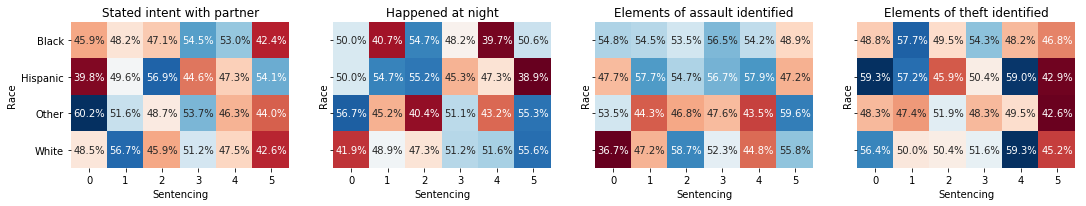

In [13]:
DI_grid()

In [14]:
def DI_grid():
    num_stages = Y.columns.size - 1
    f, axes = plt.subplots(1, num_stages, figsize=(2+4*num_stages, 12), squeeze=True, sharey=True)
    for ax, stage, cond in zip(axes, Y.columns[1:], Y.columns):
        rates = Y[Y[cond]][stage].groupby(level=['Race','Stage of Legal Procedure']).apply(base_rate)
        sns.heatmap(rates.unstack(), annot=True, fmt='.1%', cmap='RdBu', center=base_rate(Y[Y[cond]][stage]), robust=True, cbar=False, square=True, ax=ax);
        ax.set_title(f'{stage}')#' | {cond}')
    plt.close()
    return f

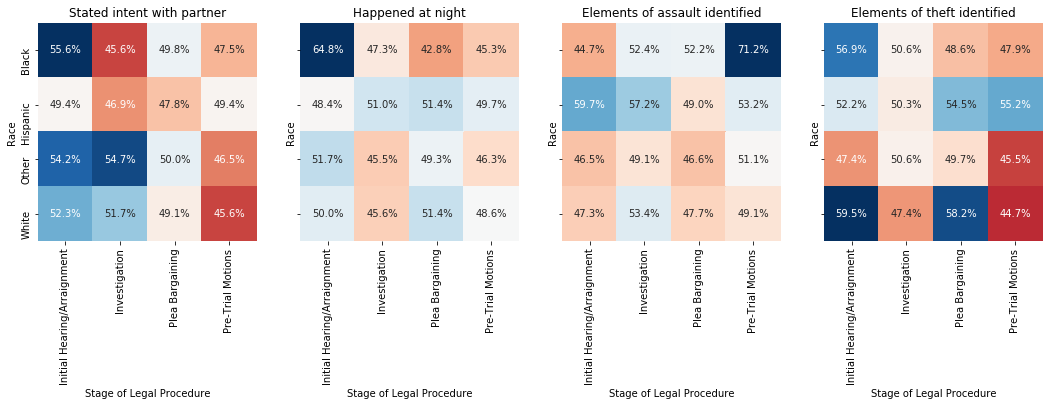

In [15]:
DI_grid()

## Disparity around different Stages of Legal Process

In [16]:
df2 = df.groupby(['Race','Stage of Legal Procedure']).size().reset_index(name="Count")
df2

,Race,Stage of Legal Procedure,Count
0,Black,Initial Hearing/Arraignment,132
1,Black,Investigation,468
2,Black,Plea Bargaining,535
3,Black,Pre-Trial Motions,117
4,Hispanic,Initial Hearing/Arraignment,320
5,Hispanic,Investigation,319
6,Hispanic,Plea Bargaining,309
7,Hispanic,Pre-Trial Motions,324
8,Other,Initial Hearing/Arraignment,305
9,Other,Investigation,336


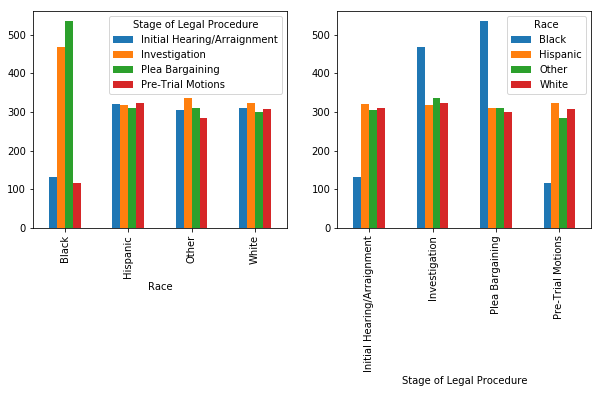

In [17]:
df3 = pd.pivot_table(df2,  values='Count',  columns=['Stage of Legal Procedure'],  index = "Race",
                         aggfunc=np.sum,  fill_value=0)
df4 = pd.pivot_table(df2,  values='Count',  columns=['Race'],  index = "Stage of Legal Procedure",
                         aggfunc=np.sum,  fill_value=0)

fig, ax = plt.subplots(1,2, figsize=(10,4))
df3.plot(kind="bar", ax=ax[0])
df4.plot(kind="bar", ax=ax[1])

plt.show()

## Disparity around Sentencing

In [20]:
df = pd.read_csv("data/weighted_random_df_v0.2.csv", usecols=[1,2,3,4,5,6,7,8])
df2 = df.groupby(['Race','Sentencing']).size().reset_index(name="Count")
df2

,Race,Sentencing,Count
0,Black,0,17
1,Black,1,27
2,Black,2,25
3,Black,3,53
4,Black,4,60
5,Black,5,66
6,Hispanic,0,29
7,Hispanic,1,50
8,Hispanic,2,49
9,Hispanic,3,64


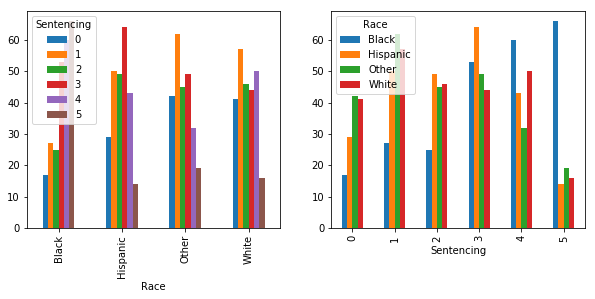

In [21]:
df3 = pd.pivot_table(df2,  values='Count',  columns=['Sentencing'],  index = "Race",
                         aggfunc=np.sum,  fill_value=0)
df4 = pd.pivot_table(df2,  values='Count',  columns=['Race'],  index = "Sentencing",
                         aggfunc=np.sum,  fill_value=0)

fig, ax = plt.subplots(1,2, figsize=(10,4))
df3.plot(kind="bar", ax=ax[0])
df4.plot(kind="bar", ax=ax[1])

plt.show()